E01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

In [134]:
import torch
import matplotlib.pyplot as plt
import string
import itertools
import random

words=open('names.txt','r').read().splitlines()

N = torch.ones((729,27),dtype=torch.int32)

In [124]:
letters = string.ascii_lowercase
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos = {i:s for s,i in stoi.items()}

letters = '.'+letters
pairs = list(itertools.product(letters,repeat=2))
pairs = [''.join(pair) for pair in pairs]
ptoi = {pair:i for i,pair in enumerate(pairs)}
itop = {i:p for p,i in ptoi.items()}


In [125]:
#COUNTING 
for w in words:
    chs=['.']+['.']+list(w)+['.']
    for char1,char2,char3 in zip(chs,chs[1:],chs[2:]):
        p1,p2 = ptoi[char1+char2],stoi[char3]
        N[p1,p2]+=1

strings = [[itop[j]+itos[i] for i in range(27)] for j in range(729)]
#print(strings)
#print(N)

P = N.float()
P/=P.sum(1,keepdim=True)
#print(P)

for i in range(10):
    name = '..'
    while True:
        p=P[ptoi[name[-2:]]]
        ix = torch.multinomial(p,num_samples=1,replacement=True).item()
        if ix==0:
            break
        name+=itos[ix]
    print(name[2:])


log_likelihood = 0
n=0
for w in words:
    chs=['.']+list(w)+['.']
    ps = [chs[i:i+2] for i in range(len(chs)-1)]
    ps.pop()
    for ch1,ch2 in zip(ps,chs[2:]):
        ch1 = ''.join(ch1)
        n+=1
        ix1 = ptoi[ch1]
        ix2 = stoi[ch2]      
        prob = P[ix1,ix2]
        logprob = torch.log(prob)
        log_likelihood+=logprob

print(f'{log_likelihood}')
nll = -log_likelihood
print(f'{nll=}')
print(f'{nll/n}')
 

inath
brya
ale
asina
jalah
broyah
jaxie
fracypzmqookove
gian
tre
-410414.96875
nll=tensor(410414.9688)
2.092747449874878


Loss: 209275

In [126]:
#NEURAL NET
xs,ys=[],[]
for w in words:
    chs = ['.'] + ['.'] + list(w) + ['.']
    for ch1,ch2,ch3 in zip(chs,chs[1:],chs[2:]):
        ix1 = ptoi[ch1+ch2]
        ix2 = stoi[ch3]
        xs.append(ix1)
        ys.append(ix2)

xs=torch.tensor(xs)
ys = torch.tensor(ys)

In [127]:
import torch.nn.functional as F
xenc = F.one_hot(xs,num_classes=729).float()
xenc.dtype

torch.float32

In [128]:
num = xs.nelement()
W = torch.randn(729,27,requires_grad=True)

for k in range(500):
    xenc = F.one_hot(xs,num_classes=729).float()
    logits = xenc@W
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean()
    print(loss.item())

    W.grad = None
    loss.backward()
    W.data += -30*W.grad
    


3.770612955093384
3.7068216800689697
3.6494157314300537
3.5972537994384766
3.54990291595459
3.5072782039642334
3.469184160232544
3.4349889755249023
3.403782606124878
3.3747899532318115
3.3475449085235596
3.3217954635620117
3.297386407852173
3.2742018699645996
3.2521467208862305
3.2311367988586426
3.211097240447998
3.1919593811035156
3.1736602783203125
3.1561412811279297
3.139349937438965
3.123237371444702
3.107759952545166
3.092878580093384
3.07855486869812
3.064758539199829
3.0514583587646484
3.0386271476745605
3.026240587234497
3.0142760276794434
3.002711772918701
2.9915294647216797
2.980710744857788
2.970238447189331
2.960097312927246
2.9502720832824707
2.940748929977417
2.9315147399902344
2.9225564002990723
2.913862943649292
2.9054222106933594
2.897223949432373
2.8892574310302734
2.8815128803253174
2.873981475830078
2.86665415763855
2.8595218658447266
2.8525774478912354
2.8458125591278076
2.839219808578491
2.832792282104492
2.826524019241333
2.8204073905944824
2.8144373893737793
2.

Loss: 2.3258

In [129]:
output = []
for _ in range(10):
    out = []
    char1 = '.'
    char2 = '.'

    while True:
        xenc = torch.nn.functional.one_hot(torch.tensor([ptoi[char1+char2]]),num_classes=729).float()
        logits = xenc@W
        counts = logits.exp()
        probs = counts / counts.sum(1,keepdim=True)
        idx = torch.multinomial(probs,num_samples=1,replacement=True).item()
        if idx==0:
            break
        char1 = char2
        char2 = itos[idx]
        out.append(itos[idx])
    output.append(''.join(out))

for name in output:
    print(name)

kaisgxstena
ka
brishaimark
madpdmpnjyrlo
jaionnfl
alla
kexbpboak
gnnyah
wh
yopefojltzley


E02: split up the dataset randomly into 80% train set, 10% dev set, 10% test set. Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [136]:
random.shuffle(words)

trainidx = int(len(xs)*0.8)
devidx = int(len(xs)*0.9)

xs_train = xs[:trainidx]
xs_dev = xs[trainidx:devidx]
xs_test = xs[devidx:] 

ys_train = ys[:trainidx]
ys_dev = ys[trainidx:devidx]
ys_test = ys[devidx:]

In [141]:
torch.cuda.is_available()

False

3.716233730316162
dev loss: 3.7109320163726807
3.6651012897491455
dev loss: 3.6651031970977783
3.621417760848999
dev loss: 3.6267173290252686
3.582077980041504
dev loss: 3.592613935470581
3.545785665512085
dev loss: 3.5614633560180664
3.51187801361084
dev loss: 3.5325775146484375
3.4799578189849854
dev loss: 3.505544900894165
3.4497523307800293
dev loss: 3.4800918102264404
3.4210658073425293
dev loss: 3.4560256004333496
3.3937511444091797
dev loss: 3.43320894241333
3.3676977157592773
dev loss: 3.411541223526001
3.342820882797241
dev loss: 3.390943765640259
3.3190488815307617
dev loss: 3.3713507652282715
3.296323299407959
dev loss: 3.3527045249938965
3.274590015411377
dev loss: 3.334949254989624
3.2537996768951416
dev loss: 3.3180325031280518
3.233905792236328
dev loss: 3.3019039630889893
3.2148630619049072
dev loss: 3.2865121364593506
3.1966261863708496
dev loss: 3.2718100547790527
3.179151773452759
dev loss: 3.2577483654022217
3.1623950004577637
dev loss: 3.2442831993103027
3.14631223

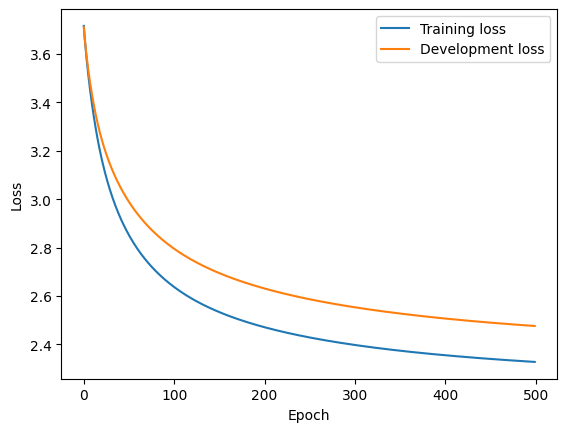

In [149]:
num = xs.nelement()
W = torch.randn(729,27,requires_grad=True)


train_losses=[]
dev_losses=[]


for _ in range(500):
    #xenc = F.one_hot(xs,num_classes=729).float()
    logits = W[xs]
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean()
    print(loss.item())
    train_losses.append(loss.item())

    with torch.no_grad():
        logits_dev = W[xs_dev]
        counts_dev = logits_dev.exp()
        probs = counts_dev / counts_dev.sum(1,keepdim=True)
        dev_loss = -probs[torch.arange(len(ys_dev)),ys_dev].log().mean()
        print(f"dev loss: {dev_loss.item()}")
        dev_losses.append(dev_loss.item())

    W.grad = None
    loss.backward()
    W.data += -30*W.grad

plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Development loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


3.7437679767608643
dev loss: 3.7423083782196045
3.6730141639709473
dev loss: 3.6771836280822754
3.6142866611480713
dev loss: 3.623917818069458
3.5644547939300537
dev loss: 3.5793895721435547
3.5214757919311523
dev loss: 3.5415618419647217
3.483448028564453
dev loss: 3.5085253715515137
3.4489710330963135
dev loss: 3.4788661003112793
3.4171714782714844
dev loss: 3.451704502105713
3.3875067234039307
dev loss: 3.426499128341675
3.3596160411834717
dev loss: 3.402897357940674
3.3332505226135254
dev loss: 3.3806610107421875
3.3082339763641357
dev loss: 3.359626054763794
3.284438371658325
dev loss: 3.3396730422973633
3.26176381111145
dev loss: 3.3207144737243652
3.2401318550109863
dev loss: 3.3026773929595947
3.2194762229919434
dev loss: 3.2855021953582764
3.199737787246704
dev loss: 3.269134998321533
3.1808648109436035
dev loss: 3.2535266876220703
3.162808656692505
dev loss: 3.2386317253112793
3.1455230712890625
dev loss: 3.2244060039520264
3.128965377807617
dev loss: 3.2108078002929688
3.113

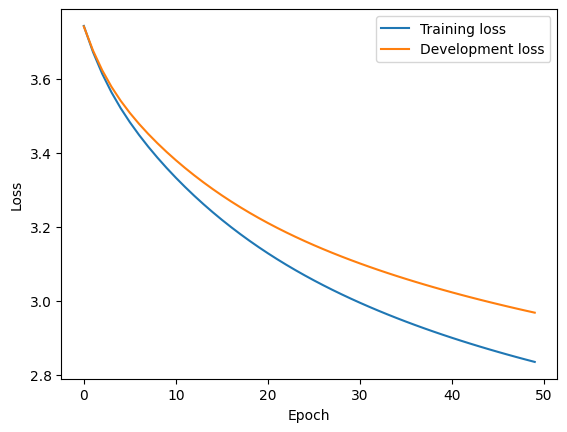

In [144]:
num = xs.nelement()
W = torch.randn(729,27,requires_grad=True)


train_losses=[]
dev_losses=[]


for _ in range(50):
    xenc = F.one_hot(xs,num_classes=729).float()
    logits = xenc@W
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean()
    print(loss.item())
    train_losses.append(loss.item())

    with torch.no_grad():
        xenc_dev = F.one_hot(xs_dev,num_classes=729).float()
        logits_dev = xenc_dev@W
        counts_dev = logits_dev.exp()
        probs = counts_dev / counts_dev.sum(1,keepdim=True)
        dev_loss = -probs[torch.arange(len(ys_dev)),ys_dev].log().mean()
        print(f"dev loss: {dev_loss.item()}")
        dev_losses.append(dev_loss.item())

    W.grad = None
    loss.backward()
    W.data += -30*W.grad

plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Development loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [145]:
xs

tensor([  0,   5, 148,  ..., 727, 701, 726])

E03: use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?


##
Just try different regularization (+1,2,3) or percentage of existing number and train and test and compare losses? Takes too much time and don't think it's that interesting. Skipping

E04: we saw that our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W?


3.747624158859253
dev loss: 3.7500088214874268
3.672469139099121
dev loss: 3.680168867111206
3.6177785396575928
dev loss: 3.6308751106262207
3.5715885162353516
dev loss: 3.5900275707244873
3.5303421020507812
dev loss: 3.5540170669555664
3.4926068782806396
dev loss: 3.5213911533355713
3.457651138305664
dev loss: 3.4914159774780273
3.4249987602233887
dev loss: 3.4636178016662598
3.3943097591400146
dev loss: 3.437655448913574
3.3653316497802734
dev loss: 3.4132750034332275
3.337877035140991
dev loss: 3.390284538269043
3.3118064403533936
dev loss: 3.3685405254364014
3.287010669708252
dev loss: 3.347928285598755
3.263401746749878
dev loss: 3.328357219696045
3.240906000137329
dev loss: 3.3097519874572754
3.2194576263427734
dev loss: 3.2920475006103516
3.1989970207214355
dev loss: 3.2751853466033936
3.179469585418701
dev loss: 3.2591140270233154
3.1608223915100098
dev loss: 3.2437846660614014
3.1430060863494873
dev loss: 3.2291526794433594
3.1259727478027344
dev loss: 3.215175151824951
3.1096

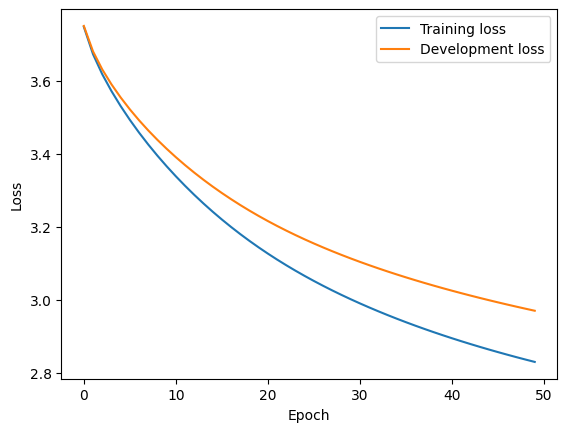

In [ ]:
num = xs.nelement()
W = torch.randn(729,27,requires_grad=True)


train_losses=[]
dev_losses=[]


for _ in range(50):
    #xenc = F.one_hot(xs,num_classes=729).float()
    #logits = xenc@W
    logits = W[xs]
    counts = logits.exp()
    probs = counts/counts.sum(1,keepdims=True)
    loss = -probs[torch.arange(num),ys].log().mean()
    print(loss.item())
    train_losses.append(loss.item())

    with torch.no_grad():
        xenc_dev = F.one_hot(xs_dev,num_classes=729).float()
        logits_dev = xenc_dev@W
        counts_dev = logits_dev.exp()
        probs = counts_dev / counts_dev.sum(1,keepdim=True)
        dev_loss = -probs[torch.arange(len(ys_dev)),ys_dev].log().mean()
        print(f"dev loss: {dev_loss.item()}")
        dev_losses.append(dev_loss.item())

    W.grad = None
    loss.backward()
    W.data += -30*W.grad

plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Development loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



**holy shit this is so much faster**

E05: look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?


3.7307417392730713
dev loss: 3.745283365249634
3.668647289276123
dev loss: 3.686978578567505
3.6142635345458984
dev loss: 3.6365230083465576
3.564939260482788
dev loss: 3.591219186782837
3.5204219818115234
dev loss: 3.550776958465576
3.4808027744293213
dev loss: 3.515263080596924
3.445873498916626
dev loss: 3.484449625015259
3.414869785308838
dev loss: 3.4575490951538086
3.3867621421813965
dev loss: 3.4334962368011475
3.3607139587402344
dev loss: 3.4114162921905518
3.3362348079681396
dev loss: 3.3907876014709473
3.31307315826416
dev loss: 3.3713395595550537
3.2910850048065186
dev loss: 3.352919578552246
3.2701683044433594
dev loss: 3.3354263305664062
3.2502403259277344
dev loss: 3.3187808990478516
3.231226682662964
dev loss: 3.302915096282959
3.213059663772583
dev loss: 3.287767171859741
3.195673942565918
dev loss: 3.273280382156372
3.1790122985839844
dev loss: 3.2594029903411865
3.1630191802978516
dev loss: 3.246086835861206
3.147646188735962
dev loss: 3.2332873344421387
3.13284826278

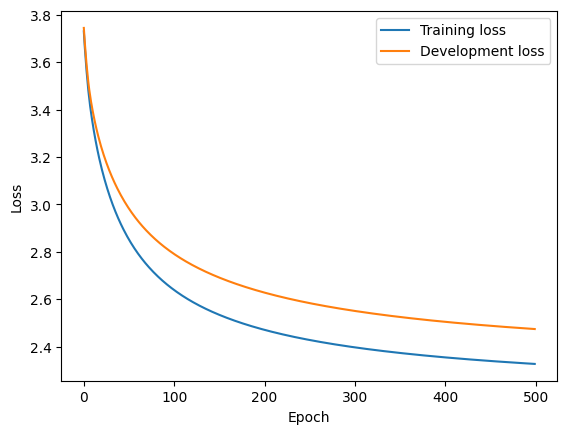

In [151]:
num = xs.nelement()
W = torch.randn(729,27,requires_grad=True)


train_losses=[]
dev_losses=[]


for _ in range(500):
    #xenc = F.one_hot(xs,num_classes=729).float()
    #logits = xenc@W
    logits = W[xs]
    #counts = logits.exp()
    #probs = counts/counts.sum(1,keepdims=True)
    #loss = -probs[torch.arange(num),ys].log().mean()
    loss = F.cross_entropy(logits,ys)
    print(loss.item())
    train_losses.append(loss.item())

    with torch.no_grad():
        #xenc_dev = F.one_hot(xs_dev,num_classes=729).float()
        logits_dev = W[xs_dev]
        #counts_dev = logits_dev.exp()
        #probs = counts_dev / counts_dev.sum(1,keepdim=True)
        #dev_loss = -probs[torch.arange(len(ys_dev)),ys_dev].log().mean()
        dev_loss = F.cross_entropy(logits_dev,ys_dev)
        print(f"dev loss: {dev_loss.item()}")
        dev_losses.append(dev_loss.item())

    W.grad = None
    loss.backward()
    W.data += -30*W.grad

plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Development loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

